In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime 

pd.options.display.max_columns
pd.set_option('display.max_columns', None)

# Data Prep

In [3]:
X_train = pd.read_csv('https://raw.githubusercontent.com/mkleinbort/Kaggle-COMPAS/main/train/X_train.csv', index_col='id')
y_train = pd.read_csv('https://raw.githubusercontent.com/mkleinbort/Kaggle-COMPAS/main/train/y_train.csv', squeeze=True)
X_test = pd.read_csv ('https://raw.githubusercontent.com/mkleinbort/Kaggle-COMPAS/main/test/X_test.csv')
# y_test = pd.read_csv('https://raw.githubusercontent.com/mkleinbort/Kaggle-COMPAS/main/test/y_test.csv') # Do not use in any way!!!

In [4]:
df = X_train

df = df.drop(['v_screening_date'], axis=1) # duplicate of 'screening_date'
df = df.drop(['v_type_of_assessment'], axis=1) # no variance
df = df.drop(['type_of_assessment'], axis=1) # no variance

df['target'] = y_train.to_list() # set target row-wise (ignoring indices)

In [5]:
# Engineer a new targets 
df['target_int'] = df['target'].replace({'No-Recidivism': 0, 'Non-Violent': 1, 'Violent': 2}) # so we can do regression
df['target_bool'] = df['target'].replace({'No-Recidivism': 0, 'Non-Violent': 1, 'Violent': 1}) # 0 - no-rec, 1 - rec

In [6]:
df.columns

Index(['name', 'first', 'last', 'sex', 'date_of_birth', 'age', 'age_group',
       'race', 'juv_fel_count', 'juv_misd_count', 'juv_other_count',
       'priors_count', 'days_b_screening_arrest', 'c_jail_in', 'c_jail_out',
       'c_offense_date', 'c_arrest_date', 'c_charge_degree', 'c_charge_desc',
       'r_jail_in', 'r_jail_out', 'screening_date', 'in_custody',
       'out_custody', 'start', 'target', 'target_int', 'target_bool'],
      dtype='object')

# Feature Engineering

In [9]:
# Engineer new date based features

"""
Custody: when someone is kept in prison until they go to court
Screening:  involves  using  a  brief  instrument  to  quickly  capture basic information 
    about a person’s risk to reoffend and is  used  to  determine  if  a  more  comprehensive  assessment
    is  warranted.  In  a  jail  setting,  everyone,  regardless  of  legal  status, should be screened 
    at booking.  Risk  screening  divides  the  jail  population  into  high-,  medium-,  and  low-risk 
    categories,  making  it  possible  to  direct  intervention  resources  first  to  the highest-risk individuals.



- c_arrest_date and c_offense_date are mutually exclusive and one of them is 99.8% likely to be filled
- start is number of days between c_jail_in and c_jail_out, maybe worth engineering total hours/minutes between
- screening_date is always filled
- r_jail_in - second time a person went to jail? 'r' for recidivism?
    sometimes has c_jail_in repeated, worth data cleaning to make sure this doesn't happen
"""



days_cols = []

def days_between(d1, d2):
    try:
        try:
            d1 = datetime.strptime(d1, "%Y-%m-%d")
        except ValueError:
            d1 = datetime.strptime(d1, "%Y-%m-%d %H:%M:%S")
            
        try:
            d2 = datetime.strptime(d2, "%Y-%m-%d")
        except ValueError:
            d2 = datetime.strptime(d2, "%Y-%m-%d %H:%M:%S")
        return abs((d2 - d1).days)
    except TypeError as e:
        return None

# mutually exclusive and one of them is always filled
df['c_bad_date'] = df['c_arrest_date'].fillna(df['c_offense_date']).fillna(df['in_custody']).fillna(df['screening_date'])

# how many days in custody
df['custody_days'] = df.apply(lambda x: days_between(x.out_custody, x.in_custody), axis=1)

# how quickly after going into custody did the person get screened (might indicate something?)
df['in_custody_to_screening_days'] = df.apply(lambda x: days_between(x.in_custody, x.screening_date), axis=1)

# questionable col because it is age related...
df['birth_to_bad_days'] = df.apply(lambda x: days_between(x.date_of_birth, x.c_bad_date), axis=1)

# How many days passed until recidivism occcured
df['days_until_recidivism'] = df.apply(lambda x: days_between(x.c_jail_out, x.r_jail_in), axis=1)

date_cols = [ 
    'c_arrest_date', 
    'c_offense_date',
    'screening_date', 
    'in_custody', 
    'out_custody', 
    'date_of_birth',
    'c_jail_in',
    'c_jail_out',

    # engineered
    'c_bad_date'
]

duration_cols = [
    'days_b_screening_arrest',
    'custody_days',
    'in_custody_to_screening_days',
    'birth_to_bad_days',
    'days_until_recidivism',
]

df.head()

,name,first,last,sex,date_of_birth,age,age_group,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_offense_date,c_arrest_date,c_charge_degree,c_charge_desc,r_jail_in,r_jail_out,screening_date,in_custody,out_custody,start,target,target_int,target_bool,c_bad_date,custody_days,in_custody_to_screening_days,birth_to_bad_days,days_until_recidivism
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2677,nicholas staggewise,nicholas,staggewise,Male,1994-02-28,22,Less than 25,Caucasian,0,0,0,2,-1.0,2013-09-23 09:01:58,2013-09-27 03:54:42,NaN,2013-09-23,F,arrest case no charge,NaN,NaN,2013-09-24,2013-09-23,2013-09-27,3,No-Recidivism,0,0,2013-09-23,4.0,1.0,7147,NaN
548,newton smith,newton,smith,Male,1995-01-28,21,Less than 25,African-American,0,1,0,1,-1.0,2013-06-16 12:36:42,2013-06-16 07:01:42,2013-06-15,NaN,F,Grand Theft in the 3rd Degree,NaN,NaN,2013-06-17,2013-06-16,2013-06-16,0,Violent,2,1,2013-06-15,0.0,1.0,6713,NaN
4483,terrance irvin,terrance,irvin,Male,1984-04-10,32,25 - 45,African-American,0,0,0,6,-1.0,2013-10-11 05:38:14,2013-10-15 07:11:17,2013-10-11,NaN,F,Grand Theft in the 3rd Degree,2013-12-21,2014-02-21,2013-10-12,2013-10-11,2013-10-15,3,Non-Violent,1,1,2013-10-11,4.0,1.0,10776,66.0
9476,jaimie peterson,jaimie,peterson,Female,1986-01-02,30,25 - 45,African-American,0,0,0,3,-1.0,2014-01-11 06:56:43,2014-01-12 02:17:00,2014-01-11,NaN,F,Felony Driving While Lic Suspd,NaN,NaN,2014-01-12,2014-01-11,2014-01-12,0,No-Recidivism,0,0,2014-01-11,1.0,1.0,10236,NaN
199,ritesh sukhlall,ritesh,sukhlall,Male,1987-05-12,28,25 - 45,Caucasian,0,0,0,2,NaN,NaN,NaN,NaN,2013-03-21,F,arrest case no charge,NaN,NaN,2013-08-29,NaN,NaN,0,No-Recidivism,0,0,2013-03-21,NaN,NaN,9445,NaN


In [10]:
# Has recidivism occured?
df['has_r_jail_in'] = df['r_jail_in'].notna()

# Has left jail after recidivism?
df['has_r_jail_out'] = df['r_jail_out'].notna()

# EDA

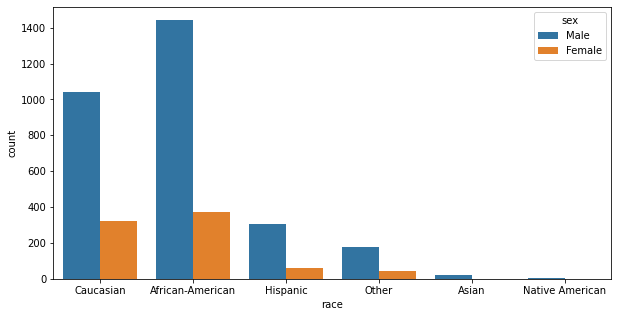

In [11]:
f, ax = plt.subplots(figsize=(10, 5))
g = sns.countplot(data=df, x='race', hue='sex', ax=ax)

<ipython-input-12-283b78a1b9f3>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(df['race'].unique(), rotation=30)


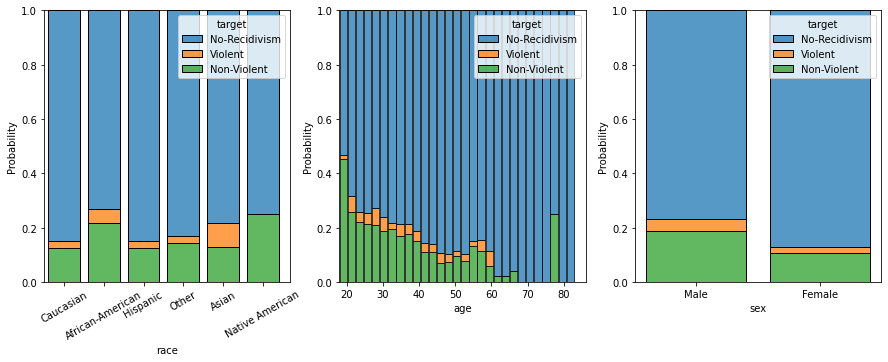

In [12]:
# Recidivism probabilities per target groups
f, axs = plt.subplots(1, 3, figsize=(15, 5))
g = sns.histplot(df, x="race", hue="target", stat="probability", multiple="fill", shrink=.8, ax=axs[0])
g.set_xticklabels(df['race'].unique(), rotation=30)

g = sns.histplot(df, x="age", hue="target", stat="probability", multiple="fill", shrink=.9, ax=axs[1])

g = sns.histplot(df, x="sex", hue="target", stat="probability", multiple="fill", shrink=.8, ax=axs[2])

In [13]:
print('count')
display(pd.crosstab(df.sex, df.race))
print('median')
display(df.groupby(['sex','race']).age.median().unstack())
print('mean')
display(df.groupby(['sex','race']).age.mean().unstack())

count


race,African-American,Asian,Caucasian,Hispanic,Native American,Other
sex,,,,,,
Female,370,1,320,62,1,43
Male,1443,22,1041,304,7,180


median


race,African-American,Asian,Caucasian,Hispanic,Native American,Other
sex,,,,,,
Female,30.0,34.0,38.0,34.5,45.0,35.0
Male,30.0,32.5,37.0,34.5,29.0,32.0


mean


race,African-American,Asian,Caucasian,Hispanic,Native American,Other
sex,,,,,,
Female,33.056757,34.000000,38.790625,36.112903,45.000000,35.906977
Male,33.916840,36.681818,39.060519,36.687500,31.714286,35.588889


[]

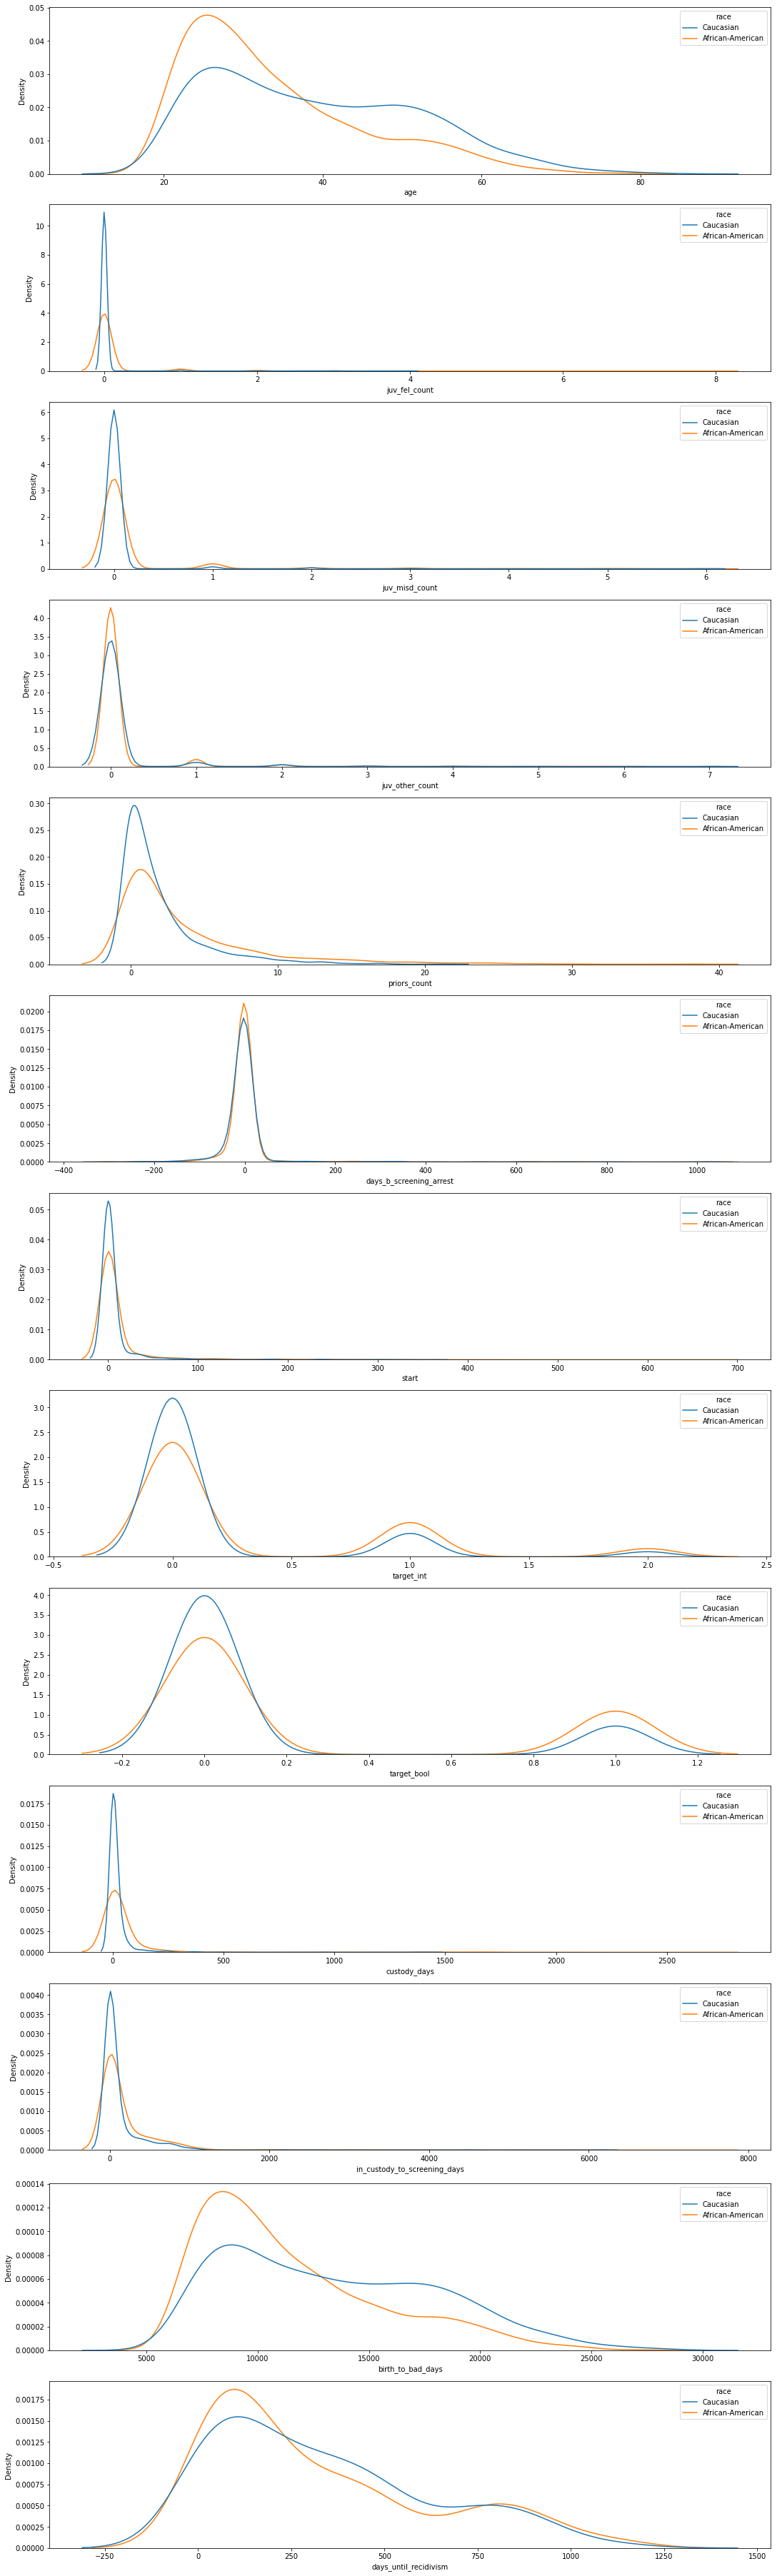

In [14]:
# Numeric against race
races = ['Caucasian', 'African-American']
cols = df.select_dtypes('number').columns
fig, axs = plt.subplots(len(cols), figsize=(15, 50), constrained_layout=True)
for col, ax in zip(cols, axs):
    sns.kdeplot(data=df[df['race'].isin(races)], x=col, hue='race', common_norm=False, ax=ax)
plt.plot()

[]

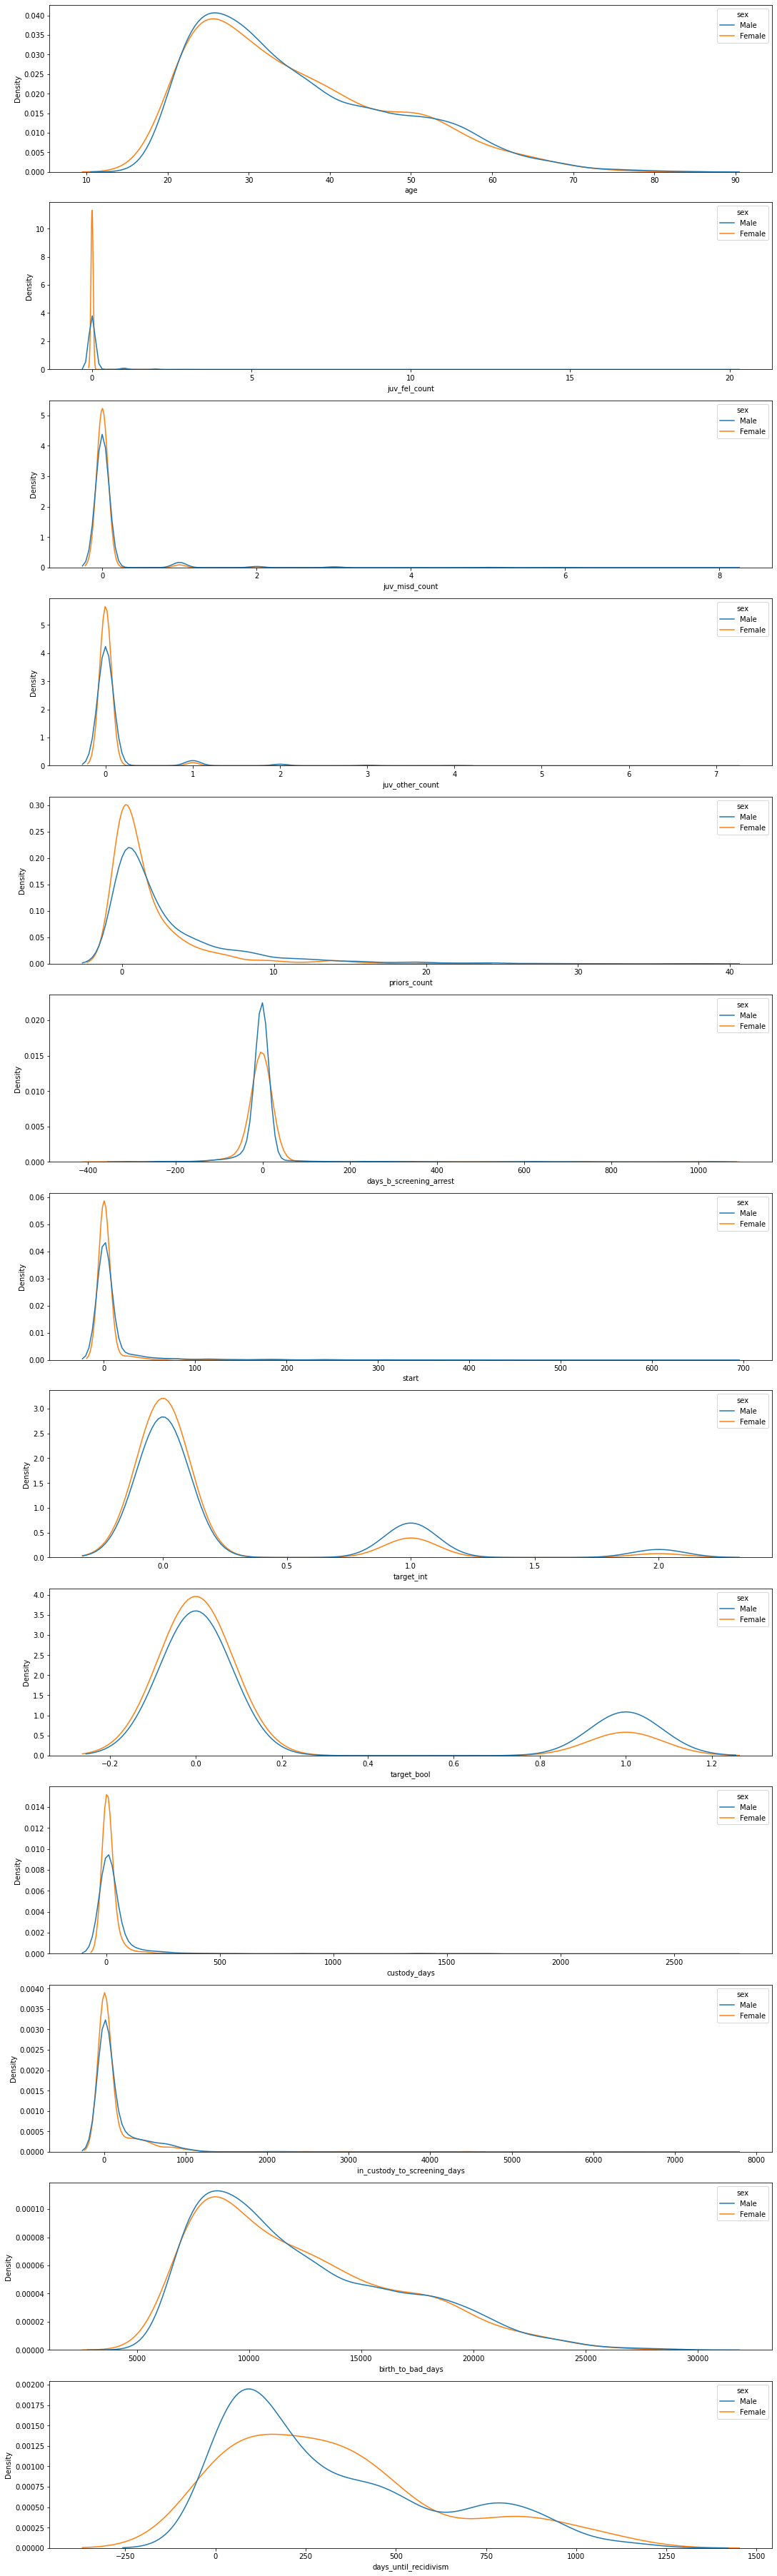

In [15]:
# Numeric against sex
cols = df.select_dtypes('number').columns
fig, axs = plt.subplots(len(cols), figsize=(15, 50), constrained_layout=True)
for col, ax in zip(cols, axs):
    sns.kdeplot(data=df, x=col, hue='sex', common_norm=False, ax=ax)
plt.plot()

<AxesSubplot:>

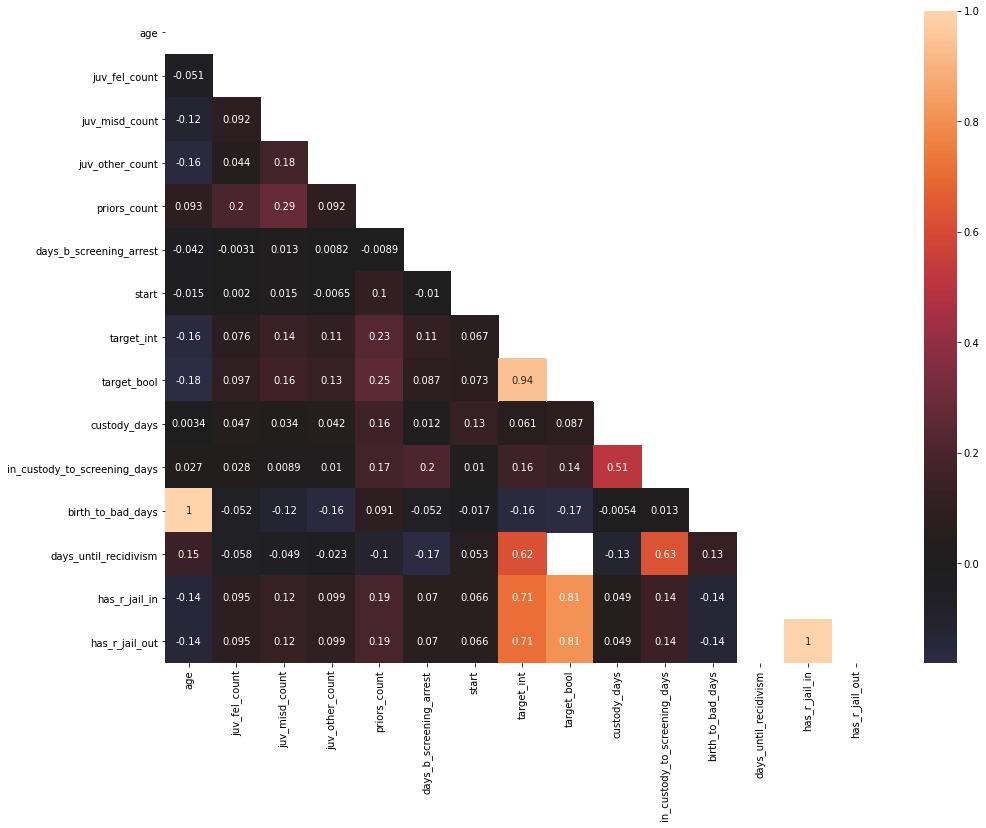

In [16]:
# Numeric correlations across numeric features
f, ax = plt.subplots(figsize=(16, 12))
corr = df.corr()
mask = np.triu(corr)
sns.heatmap(corr.select_dtypes('number'), annot=True, center=0, mask=mask)

<AxesSubplot:>

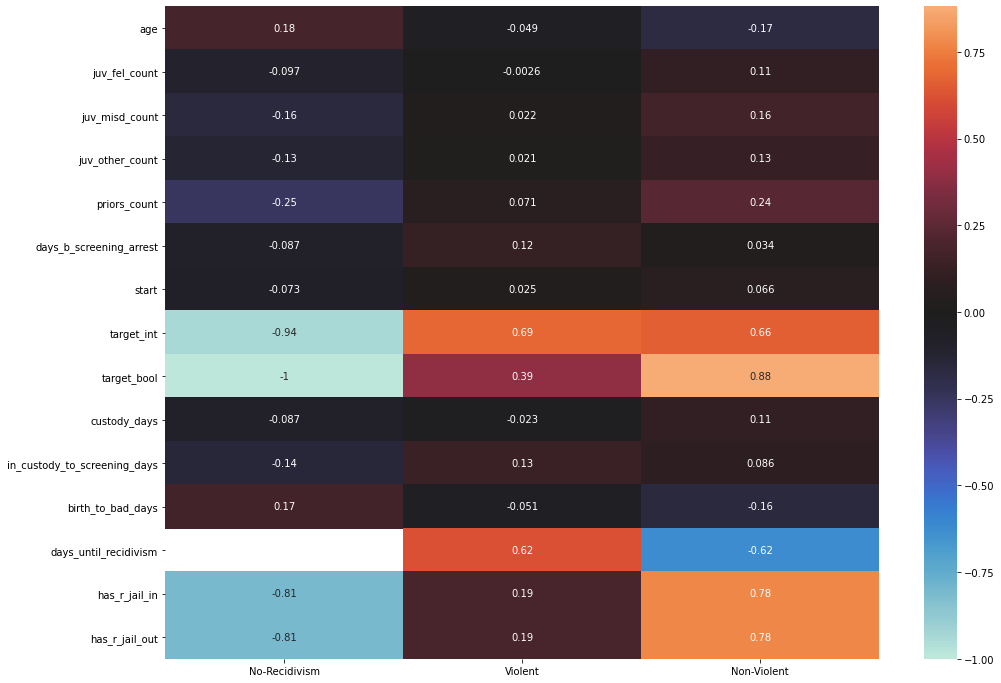

In [17]:
# Numeric correlations with targets
f, ax = plt.subplots(figsize=(16, 12))
dum = pd.get_dummies(df['target'])
cdf = pd.concat([df, dum], axis=1)
corr = cdf.corr()[df.target.unique()].drop(df.target.unique())
sns.heatmap(corr, annot=True, center=0)

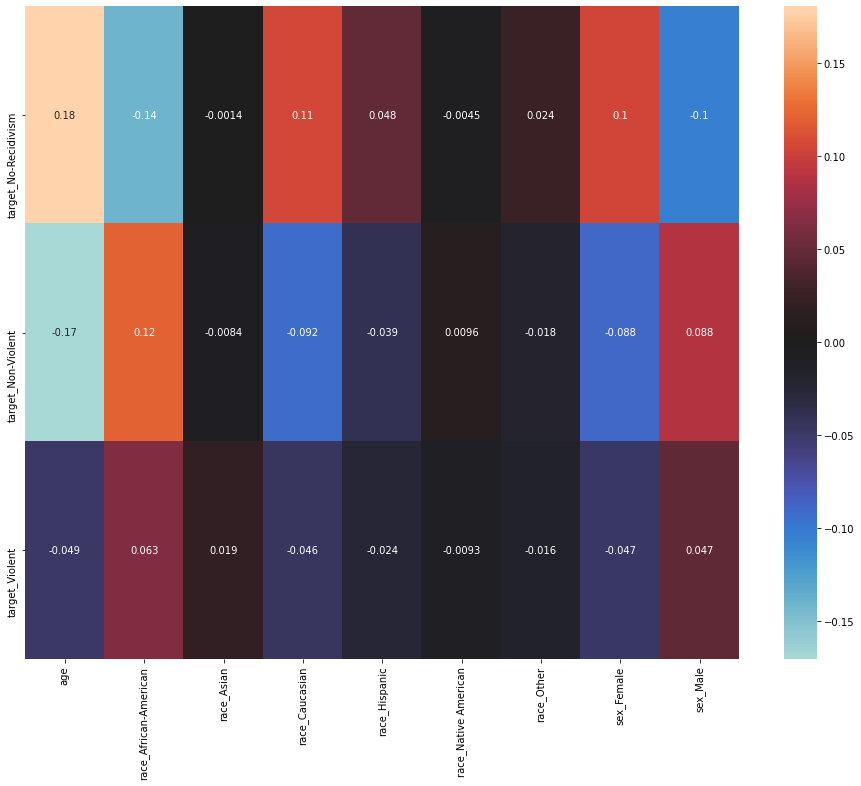

In [15]:
# Corr by race, sex, age
f, ax = plt.subplots(figsize=(16, 12))
corr = pd.get_dummies(df[['race', 'sex', 'age', 'target']]).corr()
corr = corr.drop([c for c in corr.columns if c.startswith('target_')], axis=1)[-3:]
g = sns.heatmap(corr, ax=ax, annot=True, center=0)